In [231]:
import cv2 as cv
import imutils
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

matplotlib.rc('figure', figsize=(14, 10))
#%matplotlib notebook

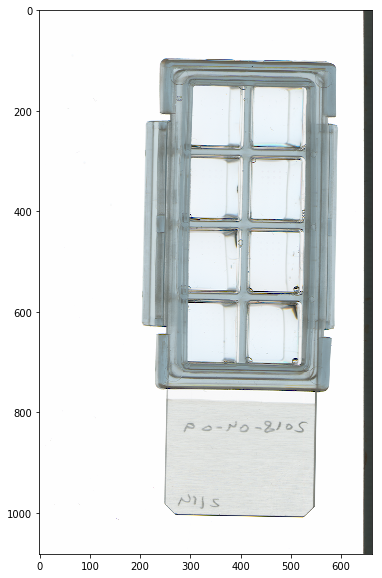

In [72]:
# Verify we can load the pictures
img = cv.imread('../test_img/02_start.tif')
plt.imshow(img)
plt.show()

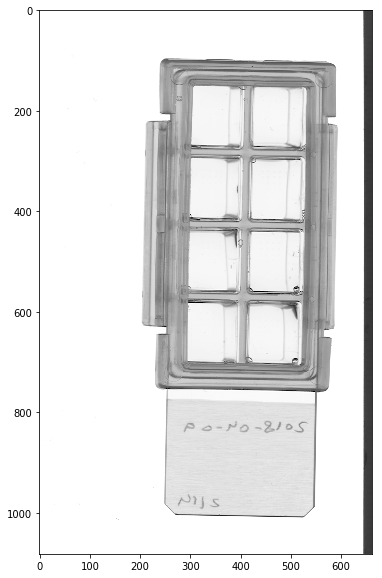

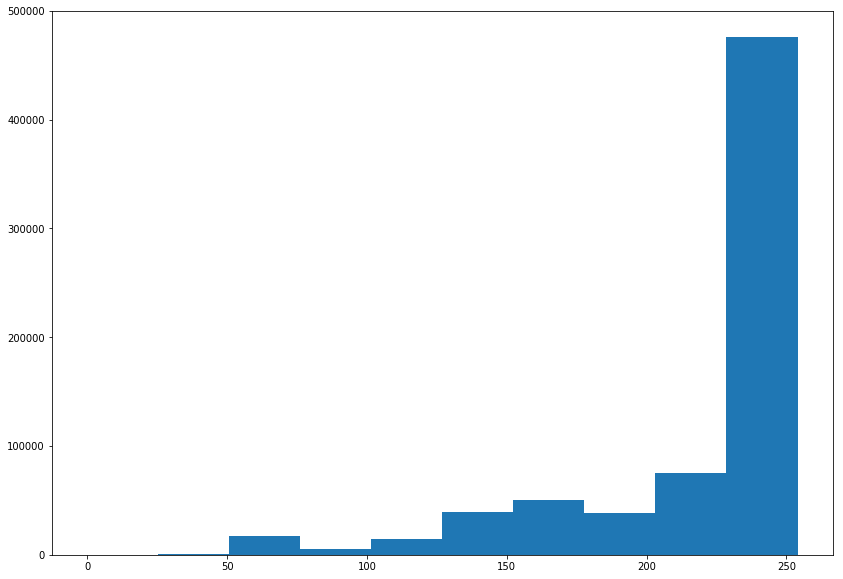

In [10]:
# Concert to grayscale
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

# Show grayscale
plt.imshow(gray, cmap='gray')
plt.show()

# Show histogram of grayscale image
fig, ax = plt.subplots()
cnts, bins, _ = plt.hist(gray.flat)
plt.show()

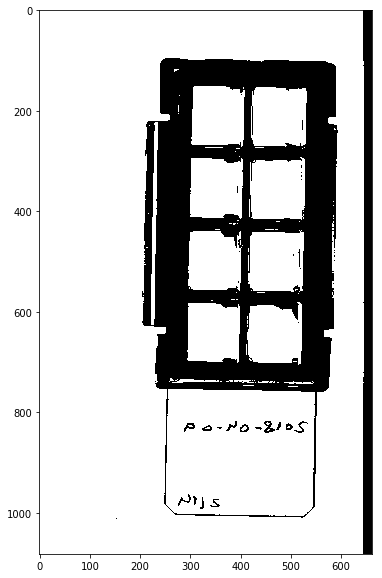

In [19]:
# Calculate a image mask in orde rto detect cells
# TODO: make the threshold a hyper parameter
ret, mask = cv.threshold(gray, 200, 255, cv.THRESH_BINARY)

plt.imshow(mask, cmap='gray')
plt.show()

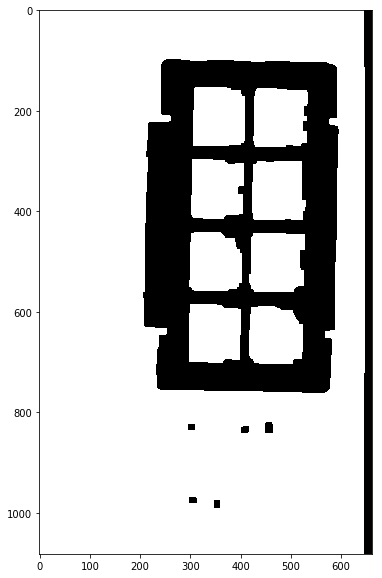

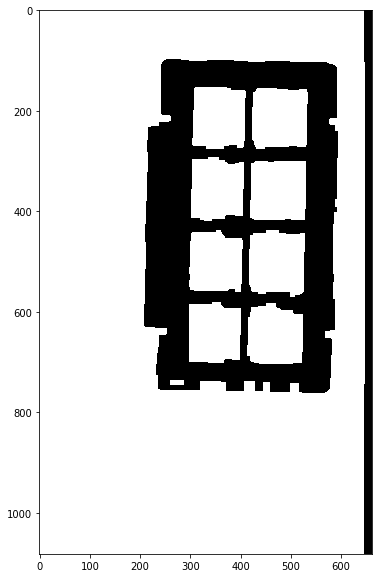

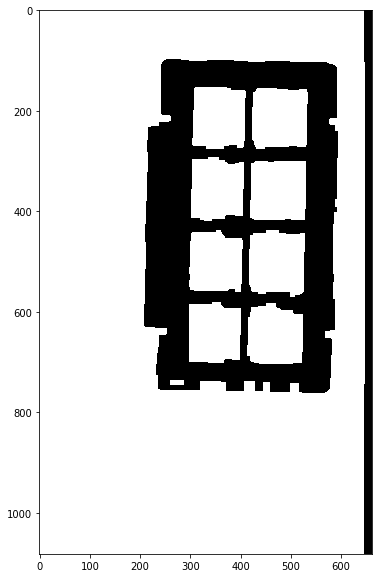

In [26]:
# Try some morphological operations to clean up mask

# TODO: make the kernel size a hyper parameter
kernel = np.ones((10,10),np.uint8)
opening = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel)
closing = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel)

opening = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel)
oc = cv.morphologyEx(opening, cv.MORPH_CLOSE, kernel)

closing = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel)
co = cv.morphologyEx(closing, cv.MORPH_OPEN, kernel)


plt.imshow(oc, cmap='gray')
plt.show()

plt.imshow(co, cmap='gray')
plt.show()

complete_mask = cv.morphologyEx(cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel), cv.MORPH_OPEN, kernel)
plt.imshow(final, cmap='gray')
plt.show()

In [145]:
# Try to extract a mask for each cell
im2,contours,hierarchy = cv.findContours(complete_mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

def get_boundingbox(contour):
    rect = cv.minAreaRect(contour)
    box = cv.boxPoints(rect)
    box = np.int0(box)
    box_area = rect[1][0]*rect[1][1]
    return box, box_area, rect
    #return cv.drawContours(img.copy(),[box],0,(0),2)    

12342.0


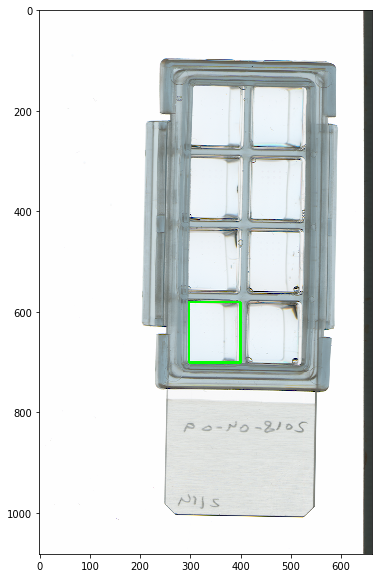

In [143]:
#plt.imshow(get_boundingbox(contours[0], im2), cmap='gray')
#plt.show()

bbox, bbox_area, rect = get_boundingbox(contours[4])

print(bbox_area)
annot_img = cv.drawContours(img.copy(), [bbox], 0, (0,255,0), 3)
plt.imshow(annot_img)
plt.show()

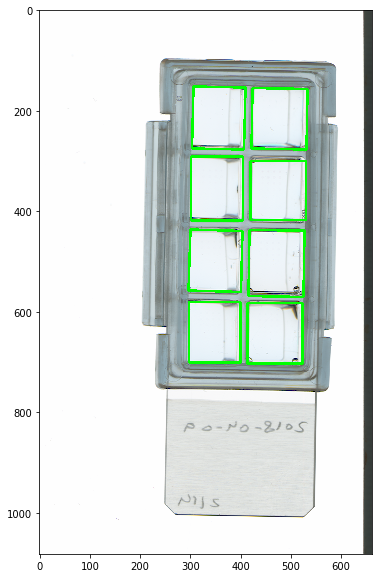

In [198]:
# Filter all contours that have reasonable size

# TODO: Add contour area size as a hyper parameter
accepted_bboxes = []
accepted_rects = []
for contour in contours:
    bbox, bbox_area, rect = get_boundingbox(contour)
    if (bbox_area > 10000) and (bbox_area < 20000):
        accepted_bboxes.append(bbox)
        accepted_rects.append(rect)

annot_img = cv.drawContours(img.copy(), accepted_bboxes, -1, (0,255,0), 3)
plt.imshow(annot_img)
plt.show()        

In [149]:
accepted_rects

[((468.5, 642.5), (109.0, 121.0), -0.0),
 ((349.0, 640.5), (102.0, 121.0), -0.0),
 ((471.8648681640625, 503.74371337890625),
  (131.6052703857422, 109.47709655761719),
  -89.06080627441406),
 ((351.333984375, 498.30950927734375),
  (121.12200164794922, 103.90045928955078),
  -88.36341857910156),
 ((475.0, 358.5), (110.0, 117.0), -0.0),
 ((354.4999694824219, 355.4999694824219),
  (102.99998474121094, 126.99998474121094),
  -0.0),
 ((477.9826965332031, 216.43484497070312),
  (120.66451263427734, 108.85172271728516),
  -88.93909454345703),
 ((357.49945068359375, 215.02378845214844),
  (122.75091552734375, 103.1136245727539),
  -88.63607025146484)]

In [252]:
# Order bounding boxes
xcenters = [rect[0][0] for rect in accepted_rects]
ycenters = [rect[0][1] for rect in accepted_rects]
roi_order = np.lexsort((xcenters, ycenters))

accepted_rects = np.array(accepted_rects)[roi_order]
accepted_bboxes = np.array(accepted_bboxes)[roi_order]

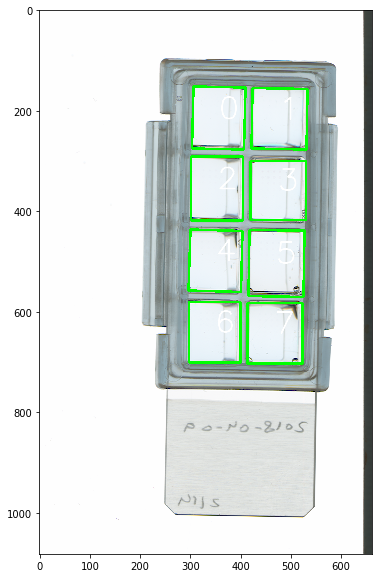

In [253]:
# Annotate bounding box in image
ordered_img = annot_img.copy()
for idx, rect in enumerate(accepted_rects):
    cv.putText(ordered_img,f'{idx}', (int(rect[0][0]), int(rect[0][1])), cv.FONT_HERSHEY_SIMPLEX, 2,(255,255,255),2,cv.LINE_AA)

plt.imshow(ordered_img)
plt.show()    

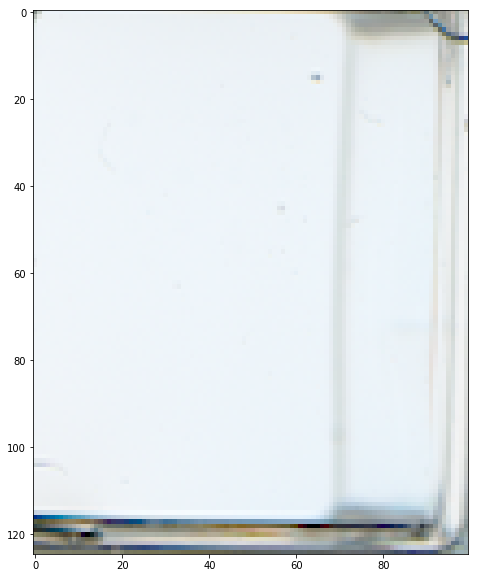

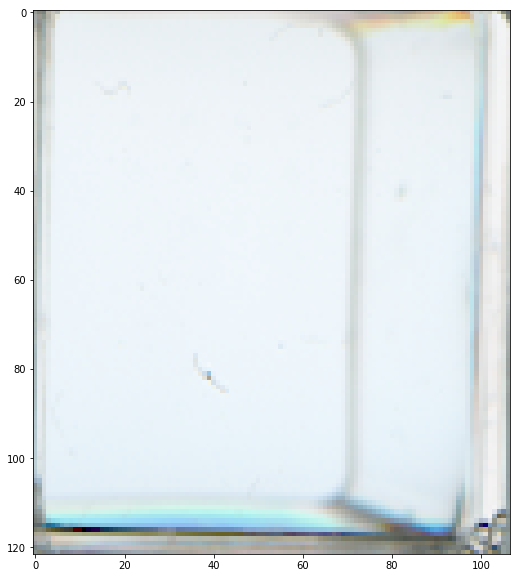

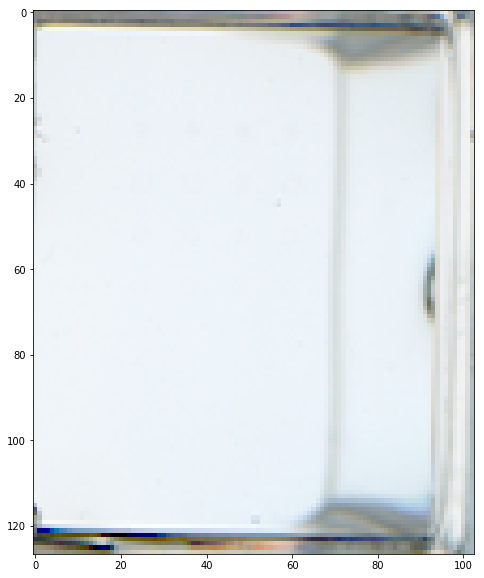

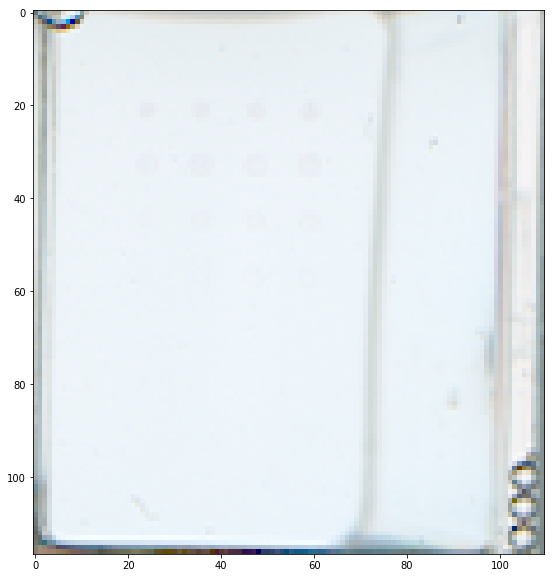

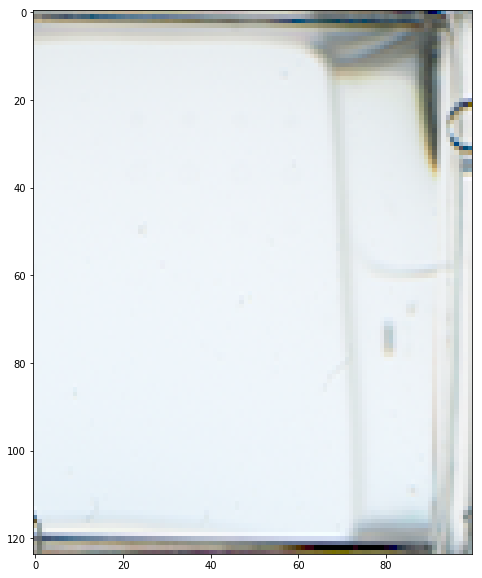

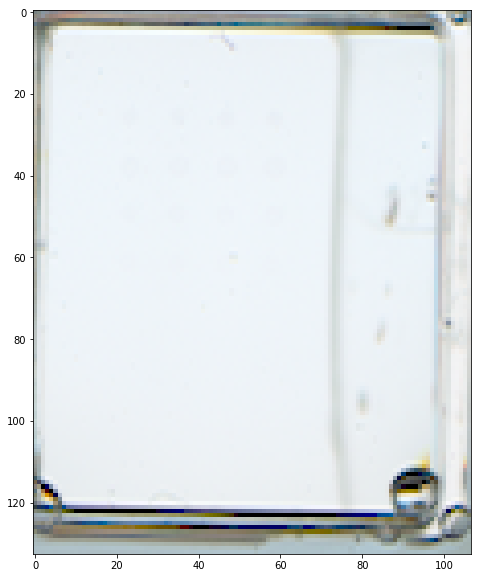

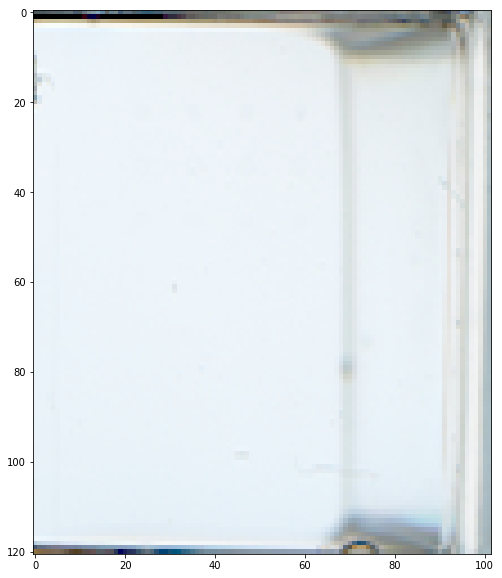

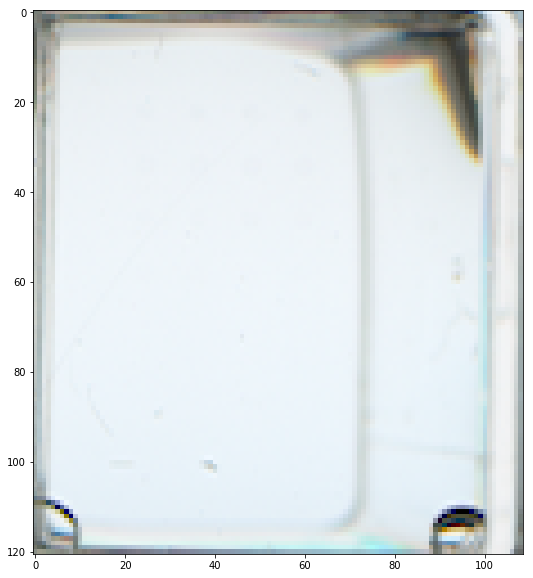

In [260]:
# Extract subimages
cells = []
for idx, bbox in enumerate(accepted_bboxes):
    #print(f'[{idx}] {bbox}, {rect}')
    xs = [b[0] for b in bbox]
    ys = [b[1] for b in bbox]
    order = np.lexsort((xs, ys))
    upper_left = bbox[order[0]]
    lower_right = bbox[order[-1]]
    x, y = upper_left[0], upper_left[1]
    xm, ym = lower_right[0], lower_right[1]

    #sub_img = ordered_img[y:ym, x:xm]
    sub_img = img[y:ym, x:xm]
    rotation = rect[2]
    if rotation < 0.0:
        rotation = 90 + rotation
    #print(f'{rect[2]}, {rotation}')
    rotated_sub_image = imutils.rotate(sub_img, rotation)
    
    plt.imshow(rotated_sub_image)
    plt.show()
    
    cells.append(rotated_sub_image)